# 3D mode solver

big project

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytrans.analysis import mode_solver as ms

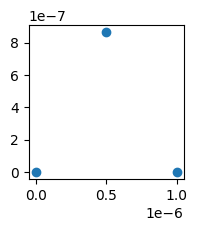

In [3]:
# test: three charges in a triangle

ll = 1e-6

X = np.asarray(
    [[0, 0, 0],
    [ll, 0, 0],
    [ll / 2, np.sqrt(3) / 2 * ll, 0],
    ], dtype=float
) 

fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(X[:, 0], X[:, 1], 'o')

In [4]:
r_ab = ms.distances(X)

N, d = X.shape

r1 = np.empty((N, N, d))
for a in range(N):
    for b in range(N):
        for j in range(d):
            r1[a, b, j] = (X[a] - X[b])[j]


np.all(r1 == r_ab)

True

## Equilibrium positions in harmonic trap

In [5]:
from pytrans.ions import Ca40

class Trap:
    
    def __init__(self, wx, wy, wz, d=3, ion=Ca40):
        self.cx = ion.mass / ion.charge * (2*pi*wx)**2
        self.cy = ion.mass / ion.charge * (2*pi*wy)**2
        self.cz = ion.mass / ion.charge * (2*pi*wz)**2

        self.d = d
        self.curvs = np.asarray([self.cx, self.cy, self.cz])[:d]


    def potential(self, voltages, x, y=None, z=None, mass=None):
        y = y if y is not None else 0.0
        z = z if z is not None else 0.0
        pot = 0.5 * (self.cx * x**2 + self.cy * y**2 + self.cz * z**2)
        return pot

    def gradient(self, voltages, x, y=None, z=None, mass=None):
        grad = np.stack([x, y, z][:self.d], axis=1) * self.curvs.reshape(1, -1)
        return grad

    def hessian(self, voltages, x, y=None, z=None, mass=None):
        return np.asarray([np.diag(self.curvs)] * len(x))

In [6]:
# from James98

scaled_equilibrium_positions = [
    [-0.63, 0.63],
    [-1.0772, 0.0, 1.0772],
    [-1.4368, -0.4544, 0.4544, 1.4368],
    [-1.7429, -0.8221, -0.0, 0.8221, 1.7429],
    [-2.0123, -1.1361, -0.3699, 0.3699, 1.1361, 2.0123],
    [-2.2545, -1.4129, -0.6869, -0.0, 0.6869, 1.4129, 2.2545],
    [-2.4758, -1.6621, -0.967, -0.318, 0.318, 0.967, 1.6621, 2.4758],
    [-2.6803, -1.8897, -1.2195, -0.5996, -0.0, 0.5996, 1.2195, 1.8897, 2.6803],
    [-2.8708, -2.1001, -1.4503, -0.8538, -0.2823, 0.2823, 0.8538, 1.4503, 2.1001, 2.8708],
]



 message: Converged (|x_n-x_(n-1)| ~= 0)
 success: True
  status: 2
     fun: 0.0583604621179877
       x: [-1.926e-05 -5.531e-11 ... -2.626e-11  1.217e-10]
     nit: 7
     jac: [ 1.103e-02 -9.172e-02 ... -4.455e-02  2.286e-01]
    nfev: 35

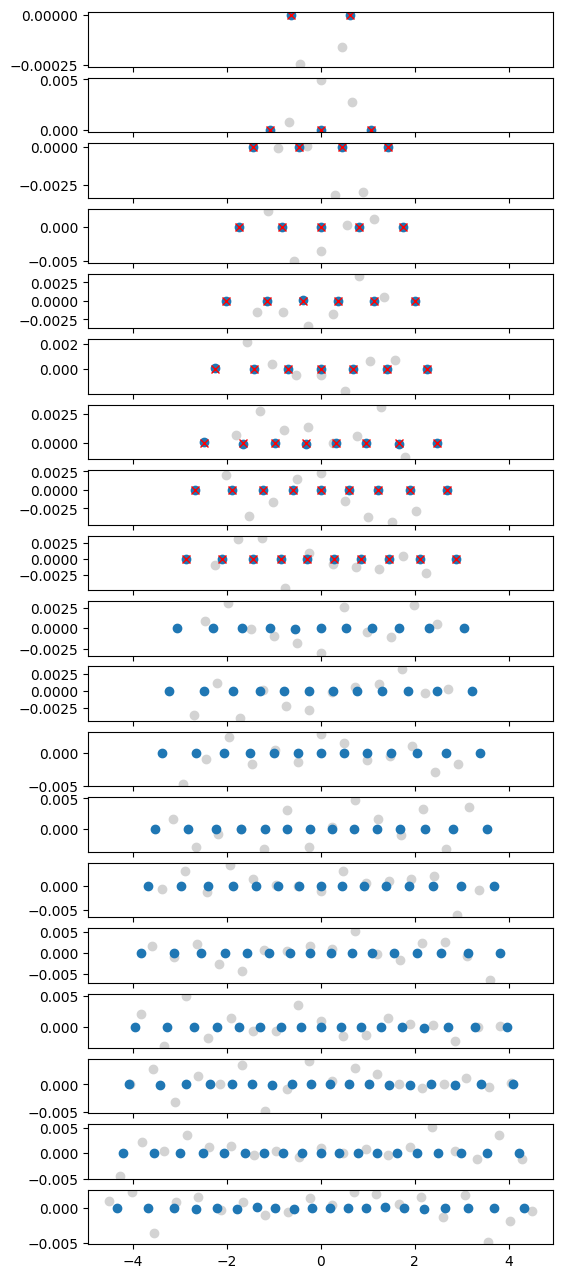

In [7]:
from scipy.constants import elementary_charge, pi

wx = 1e6
l_scale = (ms.kappa * elementary_charge / (Ca40.mass * (2*pi*wx)**2))**(1/3)

dims = 3

trap = Trap(wx=wx, wy=10e6, wz=10.457e6, d=dims)
# box = [(-40e-6, 40e-6), (-5e-6, 5e-6), (-5e-6, 5e-6)]

N_max = 20
fig, axes = plt.subplots(N_max - 1, 1, figsize=(6, 0.8 * N_max), sharex=True)

def solve_for_n_ions(trap, N_ions):
    dx = 2e-6
    x0 = ms.init_crystal((0, 0, 0), dx, N_ions)
    x0 += 1e-8 * np.random.randn(*x0.shape)
    result = ms.mode_solver(trap, x0=x0, voltages=None, ions=Ca40, bounding_box=None)
    return result, x0

for j, N_ions in enumerate(range(2, N_max + 1)):

    result, x0 = solve_for_n_ions(trap, N_ions)
    
    x_eq = result['x_eq']
    x_eq1 = x_eq[:, 0] / l_scale

    yy = x_eq[:, 1] / l_scale

    ax = axes[j]
    ax.plot(x0[:, 0] / l_scale, x0[:, 1] / l_scale, 'o', color='lightgray')
    ax.plot(x_eq1, yy, 'o')
    try:
        ax.plot(scaled_equilibrium_positions[j], np.zeros((N_ions)), 'xr', ms=6)
    except IndexError:
        pass
    # ax.set_ylim(-0.6, 0.6)
# ax.invert_yaxis()

result['res']

## Normal modes of 100 ions in harmonic trap

In [8]:
wx, wy, wz = 0.1e6, 6.5e6, 10e6
trap_freqs = np.asarray([wx, wy, wz])

trap = Trap(wx, wy, wz)
result, _ = solve_for_n_ions(trap, 100)


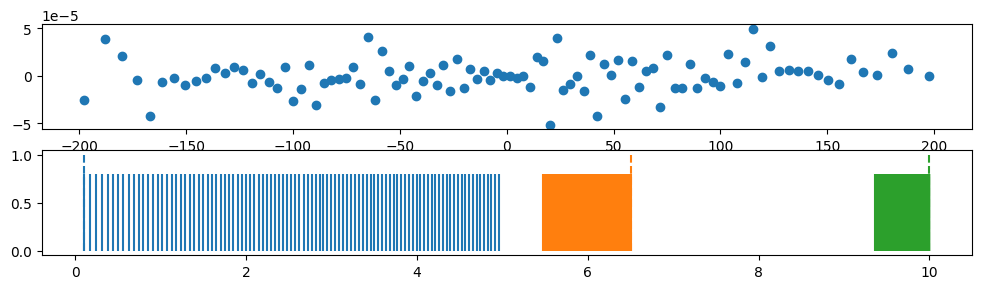

In [9]:
fig, (ax0, ax) = plt.subplots(2, 1, figsize=(12, 3))


mode_freqs = result['mode_freqs']
mode_vectors = result['mode_vectors']
x_eq = result['x_eq']

ax0.plot(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, 'o')


# projections of normal modes on single-ion eigenmodes
v1 = np.eye(3)
proj = abs(np.einsum('Mai,im', mode_vectors, v1)).sum(1)
mode1_index = np.argmax(proj, axis=1)

colors = np.asarray(['k'] * len(mode_freqs), dtype=object)
for j in range(3):
    colors[np.where(mode1_index == j)] = f"C{j}"


ax.vlines(mode_freqs * 1e-6, 0, 0.8, colors=colors)
ax.vlines(trap_freqs * 1e-6, 0, 1, colors=[f"C{j}" for j in range(3)], linestyle='--');




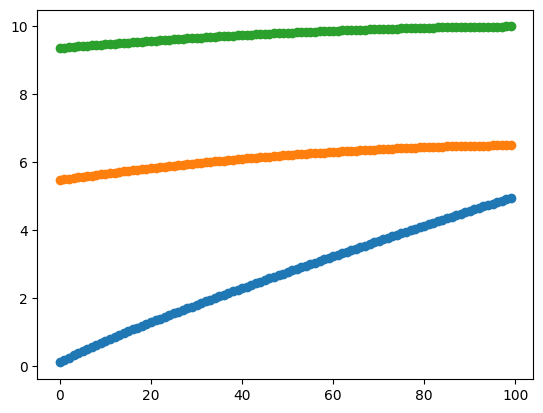

In [10]:
for j in range(3):
    plt.plot(mode_freqs[np.where(mode1_index == j)] * 1e-6, 'o')

# Mixed-species mode participation

In [13]:
from pytrans.ions import Be9
ions = [Ca40, Be9]

x0 = ms.init_crystal((0, 0, 0), dx=3e-6, n_ions=len(ions))
x0 += 1e-8 * np.random.randn(*x0.shape)
result = ms.mode_solver(trap, x0=x0, voltages=None, ions=ions, bounding_box=None)

v = result['mode_vectors']

In [15]:
# fig = plt.figure(figsize=(12, 4))
# gs = fig.add_gridspec(2, 2, hspace=0.4)

# ax_xy = fig.add_subplot(gs[0, 1])
# ax_zy = fig.add_subplot(gs[0, 0])
# ax = fig.add_subplot(gs[1, :])



# mode_freqs = result['mode_freqs']
# mode_vectors = result['mode_vectors']
# x_eq = result['x_eq']

# ax_xy.plot(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, 'o')
# ax_xy.plot(res_pot['x'] * 1e6, res_pot['y'] * 1e6, 'xr', ms=8)

# ax_zy.plot(x_eq[:, 2] * 1e6, x_eq[:, 1] * 1e6, 'o')
# ax_zy.plot(res_pot['z'] * 1e6, res_pot['y'] * 1e6, 'xr', ms=8)

# ax_xy.set(xlabel='x', ylabel='y')
# ax_zy.set(xlabel='z', ylabel='y')

# # projections of normal modes on single-ion eigenmodes
# proj = abs(np.einsum('Mai,im', mode_vectors, res_pot['eigenvectors'])).sum(1)
# mode1_index = np.argmax(proj, axis=1)

# colors = np.asarray(['k'] * len(mode_freqs), dtype=object)
# for j in range(3):
#     colors[np.where(mode1_index == j)] = f"C{j}"

# ax.vlines(mode_freqs * 1e-6, 0, 0.8, colors=colors)
# ax.vlines(res_pot['freqs'] * 1e-6, 0, 1, colors=[f"C{j}" for j in range(3)], linestyle='--');



# Solver and trap model

Loading interpolators: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


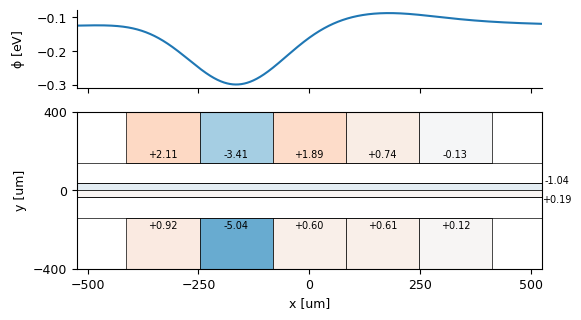

In [16]:
from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.ions import Ca40, Be9


trap = SurfaceTrap()
voltages = np.array([-1.03680679,  0.19411571,  2.10824776, -3.40701046,  1.88571987,
        0.73699269, -0.12520335,  0.91544312, -5.0391288 ,  0.59976997,
        0.60904511,  0.12365927])

_ = plot_voltages_on_trap(trap, voltages)


--------------
Analyse potential for ion Ca40: 
Exec minimize
- minimize elapsed time: 81.038 ms
Potential mimimum [um]
[-1.65004747e+02  2.36913529e-02  6.97660839e+01]
Gradient [V/m]
[-0.11704769 -0.62067765 -5.16692653]
Displacement at 1 MHz [um]
[-0.00715831 -0.03795894 -0.315995  ]
Hessian [V/m2]
[[1.63271660e+07 1.66442026e+05 1.30036549e+05]
 [1.66442026e+05 4.69879188e+08 4.99570320e+07]
 [1.30036549e+05 4.99570320e+07 3.82846303e+08]]
Normal mode frequencies [MHz]
[0.999259 5.48881 4.6929]
Eigenvectors
[[1 -0.000431 0.000144]
 [-0.000333 -0.91 -0.414]
 [-0.000309 -0.414 0.91]]
Tilt angle of mode 2 (4.69): 114.47°



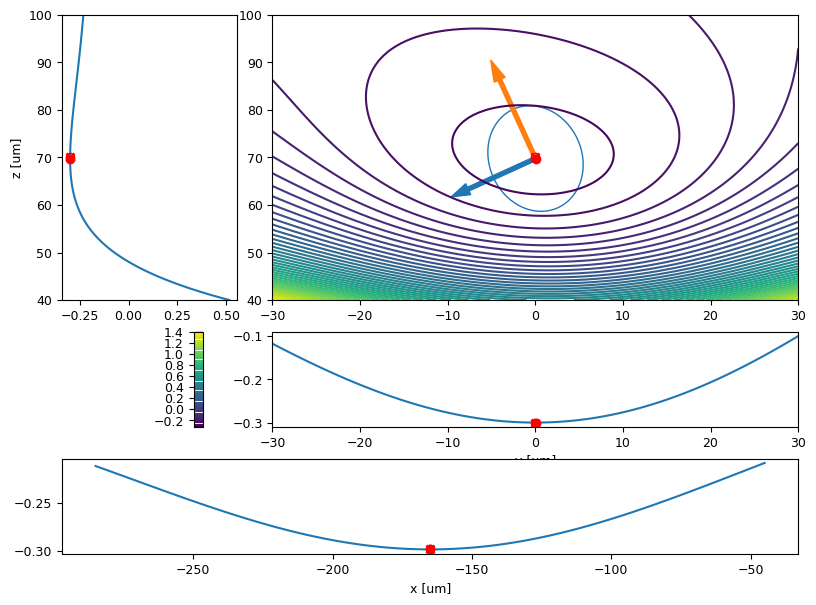

In [43]:
from pytrans.analysis import analyse_potential

r0 = (trap.x_ele(2), 0, trap.z0)

res_pot = analyse_potential(trap, voltages, ion=Ca40, r0=r0, roi=(120, 30, 30), find_3dmin=True, minimize_options=dict(accuracy=1e-8))


In [44]:
n_ions = 3

x0 = ms.init_crystal(r0, dx=3e-6, n_ions=n_ions)
x0 += 1e-8 * np.random.randn(*x0.shape)
print(x0)
result = ms.mode_solver(trap, x0=x0, voltages=voltages, ions=[Ca40, Ca40, Ca40], bounding_box=None)

[[-1.69500468e-04 -4.30324174e-09  6.99991598e-05]
 [-1.64999078e-04  5.74214863e-09  7.00185625e-05]
 [-1.60483721e-04  5.74384805e-09  7.00040285e-05]]


In [45]:
res_pot['r1'] * 1e6
res_pot['z']

6.976608388725544e-05

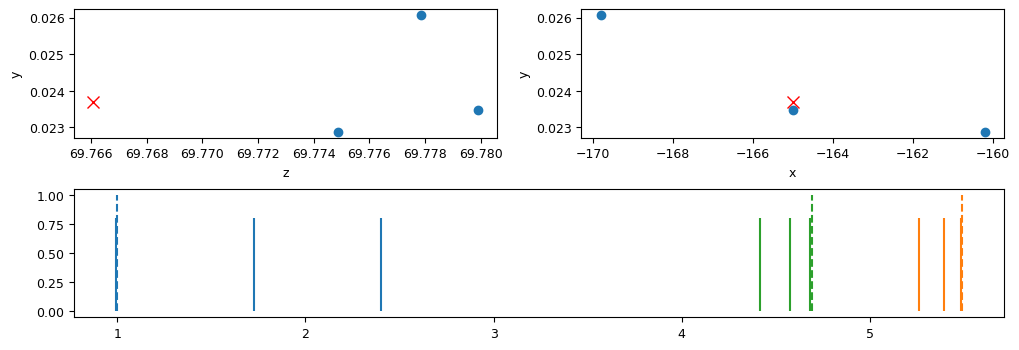

In [46]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(2, 2, hspace=0.4)

ax_xy = fig.add_subplot(gs[0, 1])
ax_zy = fig.add_subplot(gs[0, 0])
ax = fig.add_subplot(gs[1, :])



mode_freqs = result['mode_freqs']
mode_vectors = result['mode_vectors']
x_eq = result['x_eq']

ax_xy.plot(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, 'o')
ax_xy.plot(res_pot['x'] * 1e6, res_pot['y'] * 1e6, 'xr', ms=8)

ax_zy.plot(x_eq[:, 2] * 1e6, x_eq[:, 1] * 1e6, 'o')
ax_zy.plot(res_pot['z'] * 1e6, res_pot['y'] * 1e6, 'xr', ms=8)

ax_xy.set(xlabel='x', ylabel='y')
ax_zy.set(xlabel='z', ylabel='y')

# projections of normal modes on single-ion eigenmodes
proj = abs(np.einsum('Mai,im', mode_vectors, res_pot['eigenvectors'])).sum(1)
mode1_index = np.argmax(proj, axis=1)

colors = np.asarray(['k'] * len(mode_freqs), dtype=object)
for j in range(3):
    colors[np.where(mode1_index == j)] = f"C{j}"

ax.vlines(mode_freqs * 1e-6, 0, 0.8, colors=colors)
ax.vlines(res_pot['freqs'] * 1e-6, 0, 1, colors=[f"C{j}" for j in range(3)], linestyle='--');



In [41]:
(16372 + 16237)/2

16304.5

## Real waveform from segtrap

In [122]:
from model import Segtrap

In [123]:
dac_channel_transform = list(map(abs, np.array([0, 15, 3, 18, 1, 16, 4, 19, 2, 17, 5, 20, -7, 14, 6, 21,
                                  11, 26, 7, 22, 12, 27, 8, 23, 13, 28, 9, 24, -22, 29, 10, 25])))

import json
with open("../waveforms/load_split_BeCa_2022_09_28_v03_MM_comp_deaths_many_new_transports.dwc.json", 'r') as f:
    wfs = json.load(f)
samples = np.asarray(wfs['wav5']['samples'])


segtrap = Segtrap()

voltages = np.zeros((segtrap.n_electrodes,))
for i in range(len(voltages)):
    voltages[dac_channel_transform[i]] = samples[i, 0]

--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 325.562 ms
Potential mimimum [um]
[ 2.67593603e+01  1.69174743e-03 -3.04274459e-03]
Gradient [V/m]
[-0.3281834  -7.41232306 10.82874629]
Hessian [V/m2]
[[ 3.51512780e+07 -6.50005367e+04  6.04711991e+03]
 [-6.50005367e+04  1.08870372e+08  7.96888207e+07]
 [ 6.04711991e+03  7.96888207e+07  1.69242208e+08]]
Normal mode frequencies for Ca40 [MHz]
[1.4662 1.81462 3.70348]
Eigenvectors
[[-1 -0.00305 -0.000169]
 [-0.0026 0.823 0.568]
 [0.00159 -0.568 0.823]]
Tilt angle of mode 2 (3.70): 55.37°



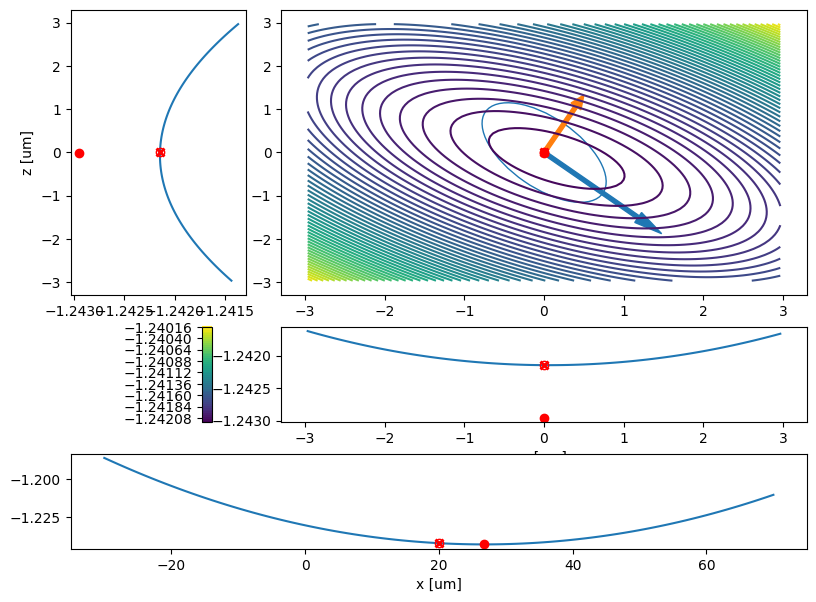

In [260]:
from pytrans.analysis import analyse_potential

res_pot = analyse_potential(segtrap, voltages, r0=(20e-6, 0, 0), roi=(50, 3.3, 3.3), find_3dmin=True, minimize_options=dict(xtol=1e-7))


In [272]:
N_ions = 2
dx = 4e-6
x0 = np.zeros((N_ions, 3), dtype=float)
x0[:, 0] = np.linspace(-N_ions / 2 * dx, N_ions / 2 * dx, N_ions) + res_pot['x']
x0 += 1e-8 * np.random.randn(*x0.shape)

result = mode_solver(segtrap, x0=x0, voltages=voltages, minimize_options=dict(xtol=1e-7))


In [269]:
result['res']

     fun: -2.485414064820236
     jac: array([ 0.00264512, -0.05589397, -0.24571129, -0.01661429,  0.19337403,
        0.1675134 ])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 13
     nit: 3
  status: 2
 success: True
       x: array([ 2.46144039e-05,  1.31111303e-07, -1.22842846e-07,  2.89568729e-05,
        2.34952975e-07, -1.83617825e-07])

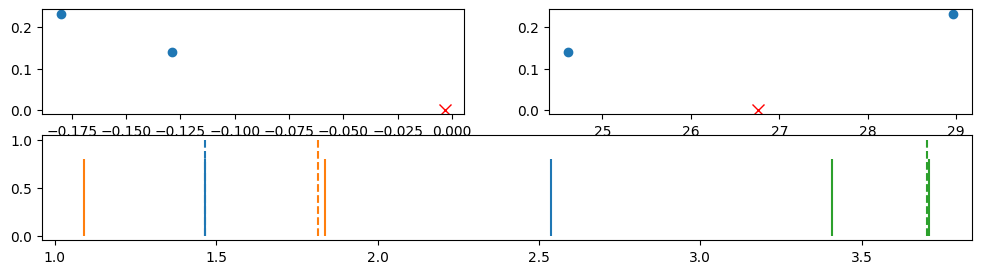

In [273]:
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(2, 2)

ax_xy = fig.add_subplot(gs[0, 1])
ax_zy = fig.add_subplot(gs[0, 0])
ax = fig.add_subplot(gs[1, :])



mode_freqs = result['mode_freqs']
mode_vectors = result['mode_vectors']
x_eq = result['x_eq']

ax_xy.plot(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, 'o')
ax_xy.plot(res_pot['x'] * 1e6, res_pot['y'] * 1e6, 'xr', ms=8)

ax_zy.plot(x_eq[:, 2] * 1e6, x_eq[:, 1] * 1e6, 'o')
ax_zy.plot(res_pot['z'] * 1e6, res_pot['y'] * 1e6, 'xr', ms=8)

# projections of normal modes on single-ion eigenmodes
proj = abs(np.einsum('Mai,im', mode_vectors, res_pot['eigenvectors'])).sum(1)
mode1_index = np.argmax(proj, axis=1)

colors = np.asarray(['k'] * len(mode_freqs), dtype=object)
for j in range(3):
    colors[np.where(mode1_index == j)] = f"C{j}"

ax.vlines(mode_freqs * 1e-6, 0, 0.8, colors=colors)
ax.vlines(res_pot['freqs'] * 1e-6, 0, 1, colors=[f"C{j}" for j in range(3)], linestyle='--');

